In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import tarfile

In [0]:
bs = 64

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1. Load data

In [5]:
!wget https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar

--2020-01-05 04:39:07--  https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar [following]
--2020-01-05 04:39:07--  https://www.dropbox.com/s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1e9126bbca0b5236c91be8bdb5.dl.dropboxusercontent.com/cd/0/inline/AvlaBAZAKv2oNC-0KZG5WBFslNyXFowfePloEuRl7WXmR1ZFodfw84dM8spis5DrIJcXXEvs4EYBXvG5YgZXt5rgFAnGSS7VqLYqmyQdiZrGCeVmoooN9coWJp6WTp1riQY/file# [following]
--2020-01-05 04:39:07--  https://uc1e9126bbca0b5236c91be8bdb5.dl.dropboxusercontent.com/cd/0/inline/AvlaBAZAKv2oNC-0KZG5WBFslNyXFowfePloEuRl7WXmR1ZFodfw84dM8spis5DrIJcXXEvs4EYBXv

In [0]:
tarred_file = tarfile.open("wildfire_smoke_data.tar")
tarred_file.extractall()
tarred_file.close()

In [10]:
%cd ..
!ls

/content
sample_data  wildfire_smoke_data  wildfire_smoke_data.tar


In [0]:
!mv `ls | head -20` ../../test/smoke

In [0]:
data = ImageDataBunch.from_folder("wildfire_smoke_data",
                                  train = 'train',
                                  valid='validate',
                                  ds_tfms=get_transforms(), 
                                  size=224, bs=bs).normalize(imagenet_stats)

Be careful! Need to be in the right directory before using ImageDataBunch.

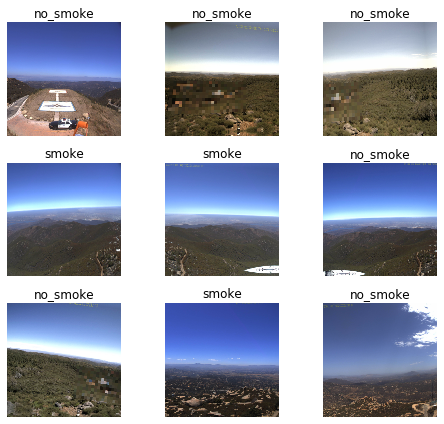

In [12]:
data.show_batch(rows=3, figsize=(7, 6))

It is difficult for human as well to detect smoke in some of those pictures.

# 2. Quick resnet model with pretrained weights



In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 306MB/s]


In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.158408,0.963515,0.387218,02:09
1,1.132276,0.776782,0.349624,02:09
2,1.034452,0.627832,0.296992,02:09
3,0.923125,0.576806,0.296992,02:08


In [18]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-1", return_path=True)

PosixPath('wildfire_smoke_data/models/stage-1.pth')

## 👉 Results

After four epochs, the error_rate is still decreasing, so this is good. But the error-rate is still not so good. Maybe the learning rate is too small.

Moreover, the train_loss is still bigger than the valid_loss. It means, that are underfitting. We should either increase the learning rate or increase the number of epochs.

# 3. Resnet model unfreezed

Let's first find the best learning rate.

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


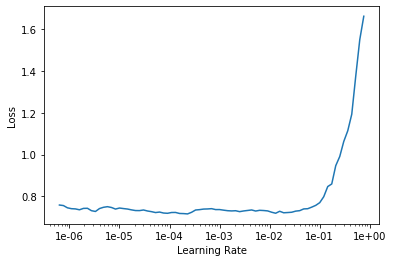

In [25]:
learn.recorder.plot()

It seems that the best learning rate for the last layers is around 0.01.

In [27]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.366632,0.419214,0.191729,02:09
1,0.367062,0.391997,0.184211,02:09
2,0.353190,0.304036,0.124060,02:09
3,0.326150,0.405575,0.120301,02:09
4,0.305696,0.374988,0.135338,02:09


In [0]:
learn.save("/content/gdrive/My Drive/fastai/wildfires/stage-2")

## 👉 Results

The error_rate is way better than before, but still quite high. The train_loss is smaller than the valid_loss, we are not underfitting anymore. However, it is possible that we are overfitting a little bit because the error_rate is increasing again in the last epoch. Maybe, we should remove one epoch.

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

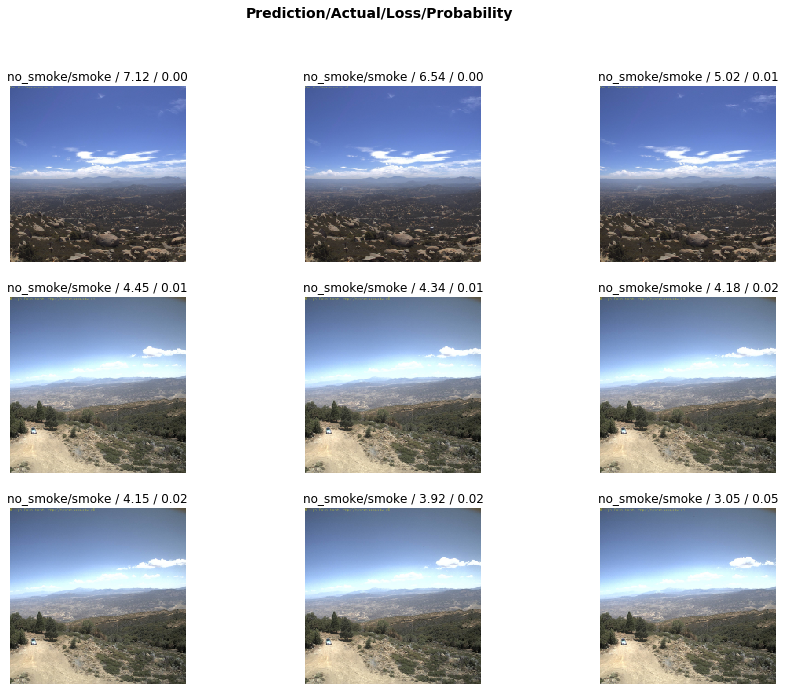

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

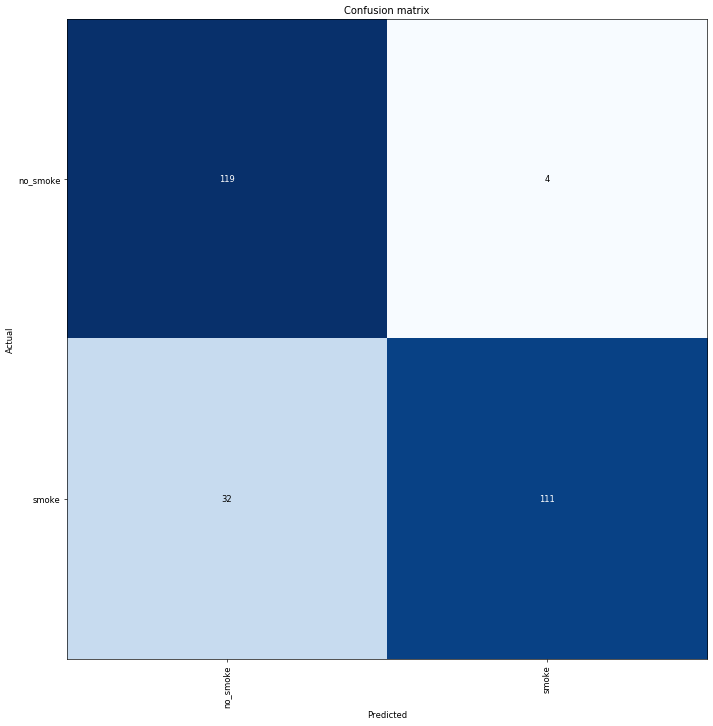

In [31]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This confusion matrix is quite bad. We would prefer to predict smoke when there is no smoke, insted of predicting no smoke when there is actually a real fire.